In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#sns.set() # matplot lib defaults
plt.rcParams['figure.figsize'] = (24, 6)
%config InlineBackend.figure_format='retina'

In [4]:
# find the notebook the saved figures came from
fig_prefix='../figures/jq-'

In [5]:
from IPython.display import FileLink
FileLink('./data_cleanup.ipynb')

/Users/jing/Documents/LambdaSchool/lambda_lab/notebooks/data_cleanup.ipynb

In [6]:
df = pd.read_sql_table('data', 'sqlite:///../data/mydb.db')  

In [7]:
df.head(3)

,id,market,product,country,date,retail,wholesale,currency,year,month,day,week
0,0,Bujumbura,Maize,Burundi,2011-10-04,NaN,548798.0,BIF,2011.0,10.0,4.0,40.0
1,1,Bujumbura,Maize,Burundi,2011-10-05,NaN,549000.0,BIF,2011.0,10.0,5.0,40.0
2,2,Bujumbura,Maize,Burundi,2011-10-06,NaN,498970.0,BIF,2011.0,10.0,6.0,40.0


In [8]:
date_selected = (df['date']>'2012-01-01' )
Market = 'Lira'
market_selected = (df['market']==Market)
product_selected = ( df['product']=='Maize')

#Let's not apply datae selected first to look into retail price chantge in long term
condition = market_selected & product_selected
df = df[condition]
df.head()

,id,market,product,country,date,retail,wholesale,currency,year,month,day,week
60302,60302,Lira,Maize,Uganda,1994-02-01,NaN,165635.0,UGX,1994.0,2.0,1.0,5.0
60303,60303,Lira,Maize,Uganda,1994-03-01,NaN,183570.0,UGX,1994.0,3.0,1.0,9.0
60304,60304,Lira,Maize,Uganda,1994-04-01,NaN,261640.0,UGX,1994.0,4.0,1.0,13.0
60305,60305,Lira,Maize,Uganda,1994-05-01,NaN,275355.0,UGX,1994.0,5.0,1.0,17.0
60306,60306,Lira,Maize,Uganda,1994-06-01,NaN,295400.0,UGX,1994.0,6.0,1.0,22.0


In [9]:
# remove duplicated row
rows_rm = df.duplicated('date', keep='last')

if np.sum(rows_rm):
    df = df[~rows_rm]
    
print(f'Length of data before removing duplicates: {len(rows_rm)}, after {len(df)}')

Length of data before removing duplicates: 2397, after 1949


In [10]:
retail = df[['date', 'retail']]
retail = retail.sort_values('date')
retail.set_index('date', inplace=True)
retail.tail(10)

,retail
date,
2020-03-03,1200001.0
2020-03-05,1200360.0
2020-03-06,1196448.0
2020-03-10,1198771.0
2020-03-12,1200456.0
2020-03-13,1200656.0
2020-03-17,1205755.0
2020-03-19,1213854.0
2020-03-25,1188807.0


In [11]:
wholesale = df[['date', 'wholesale']].sort_values('date')
wholesale.set_index('date', inplace=True)
wholesale.tail(10)

,wholesale
date,
2020-03-03,820001.0
2020-03-05,800240.0
2020-03-06,847486.0
2020-03-10,899079.0
2020-03-12,900343.0
2020-03-13,950518.0
2020-03-17,803838.0
2020-03-19,930623.0
2020-03-25,842071.0


In [12]:
# construct complete time frame
date_range = pd.date_range(start=retail.index[0], end=retail.index[-1], freq='D')

time_df=pd.DataFrame([], index=date_range)
time_df.head()

""
1994-02-01
1994-02-02
1994-02-03
1994-02-04
1994-02-05


In [13]:
# construct data sample with complete time frame
yt = time_df.merge(wholesale, how='outer', left_index=True, right_index=True)
yt.tail(10)

,wholesale
2020-03-18,NaN
2020-03-19,930623.0
2020-03-20,NaN
2020-03-21,NaN
2020-03-22,NaN
2020-03-23,NaN
2020-03-24,NaN
2020-03-25,842071.0
2020-03-26,NaN
2020-03-27,868066.0


In [14]:
yw = yt.resample('W').last()

In [15]:
print(len(yt), len(yw))

9552 1365


In [30]:
type(yt)

pandas.core.frame.DataFrame

visualization reveals different trends for different market, let's narrow down

In [89]:
def plot_one_time_series(df, color='k', alpha=1, label=Market):
    """time series of a df with datetime index"""
#     color = [0.1, 0.5, 0.5]
#     color_repeated =np.tile(np.array(color), (df.shape[0],1))
    #print(color_repeated)
    if isinstance(df, (pd.core.frame.DataFrame)):
       
        ax = fig.gca()
        ax.plot(df.index, df.values,#c = color_repeated, 
                color, label=label, alpha=alpha)
        ax.set_xlabel('Year', fontsize=20)
        ax.set_ylabel('Wholesale price by day', fontsize=20)
        ax.tick_params(axis="x", labelsize=20)
        ax.tick_params(axis="y", labelsize=20) 
        ax.legend()
        
    else:
        raise Exception('Wrong type! Plot funiction only take dataframe as input.')

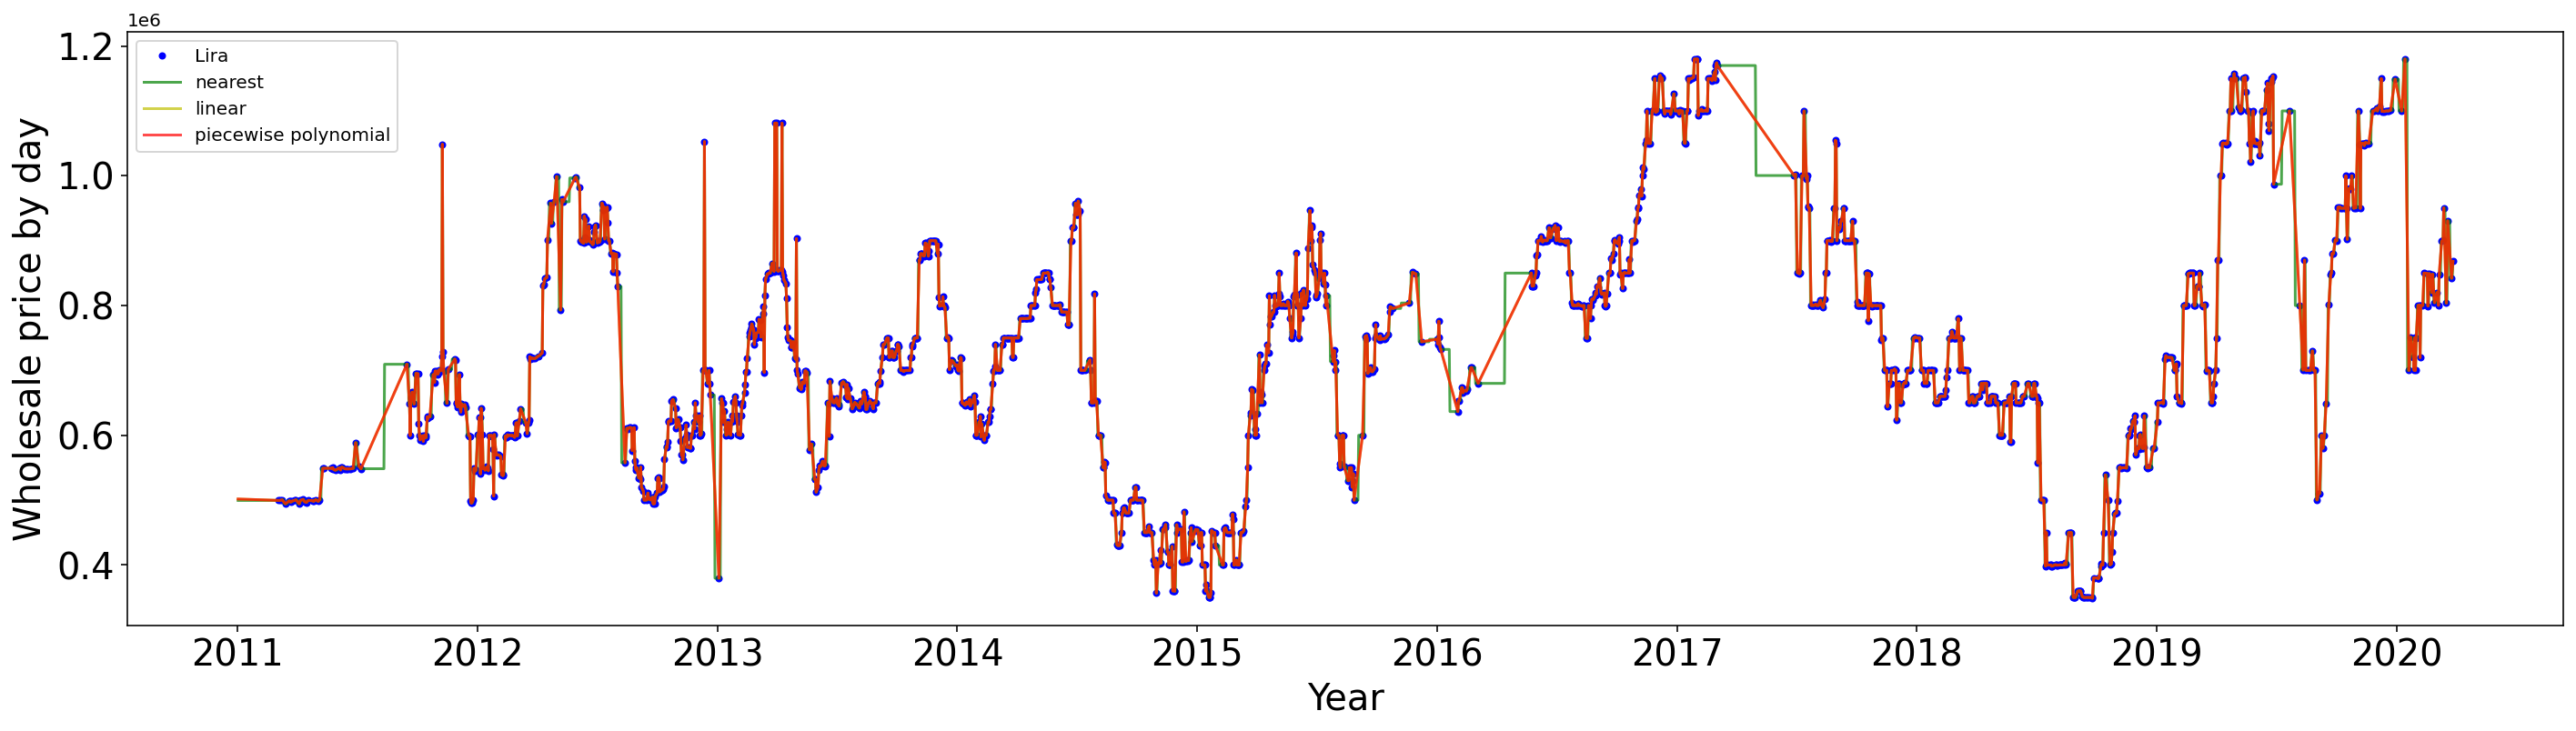

In [127]:
# replace the NaN with interpolated values and visualize for best interpolation method
# since the data is rather ragged, nerest method is picked

yt_n = yt.interpolate(method='nearest')
yt_l = yt.interpolate(method='linear')
yt_pp = yt.interpolate(method='piecewise_polynomial', order=2)

# visualize for best interpolation method
fig = plt.figure()
cond = (yt.index>'2011-01-01')
plot_one_time_series(yt[cond],'b.', label='Lira')
plot_one_time_series(yt_n[cond],'g', label='nearest', alpha=0.7)
plot_one_time_series(yt_l[cond],'y', label='linear', alpha=0.7)
plot_one_time_series(yt_pp[cond],'r', alpha=0.7, label='piecewise polynomial')

plt.show()

y_i = yt_n # interpolated y

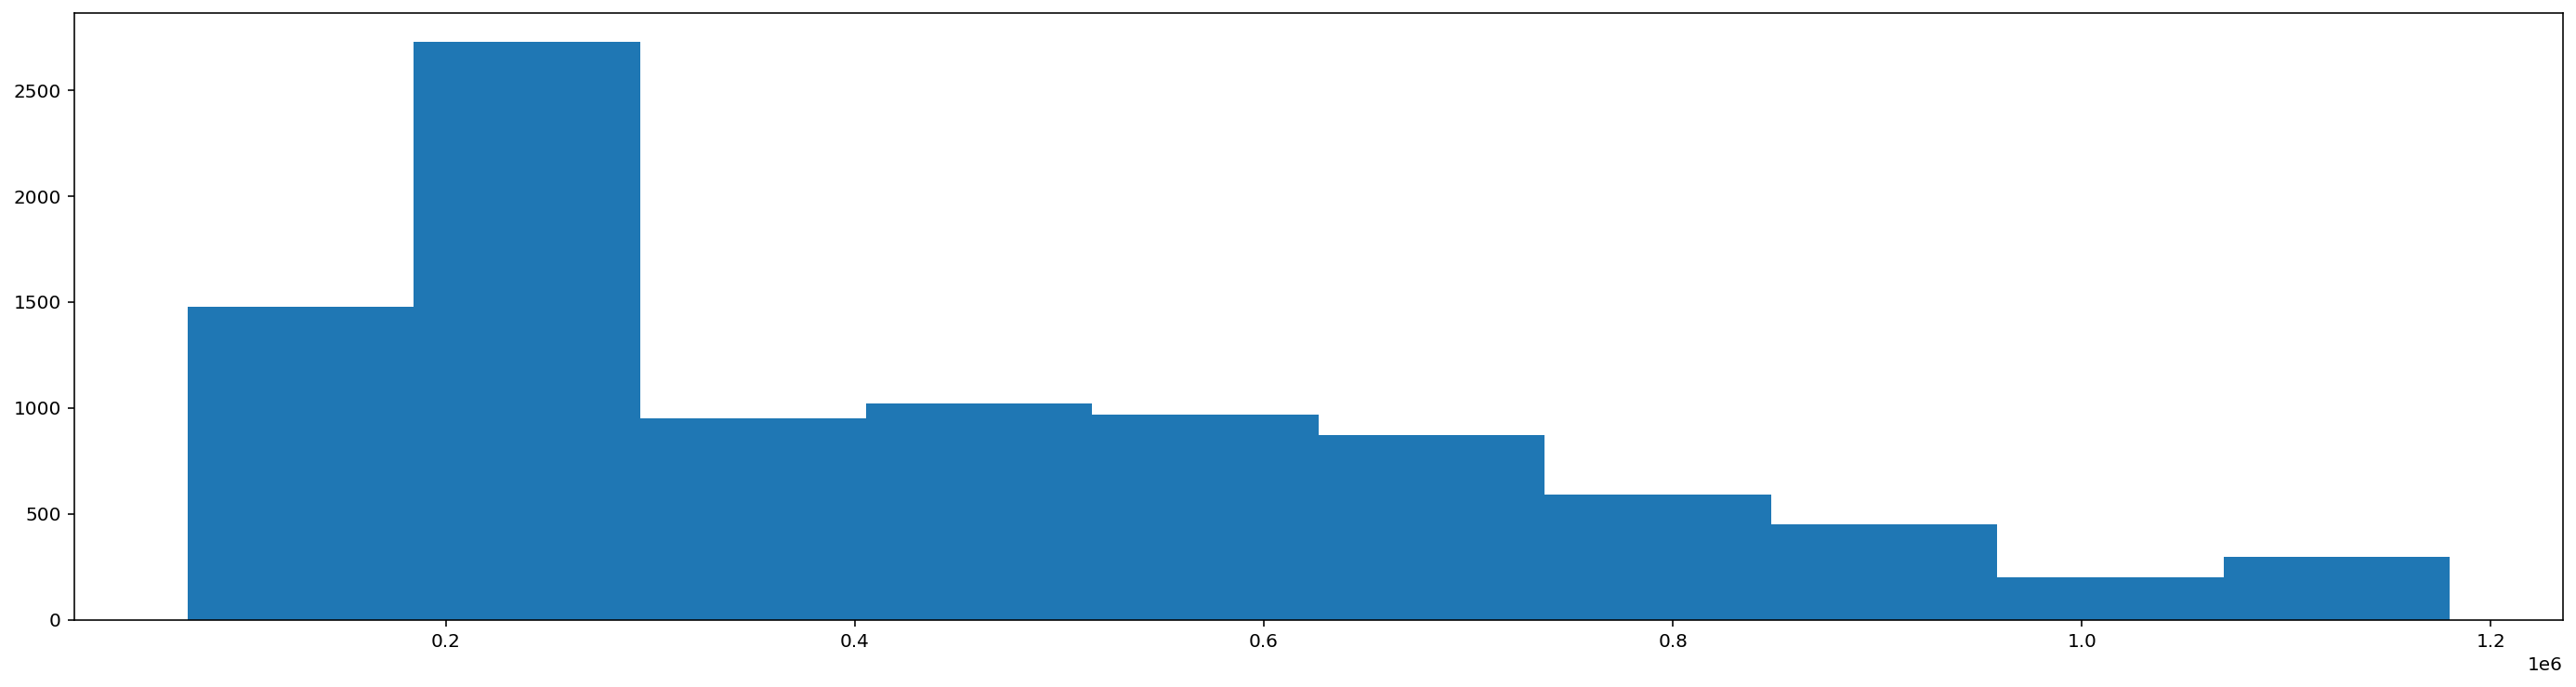

In [136]:
# check the distribution of the data
plt.hist(y_i['wholesale'])
plt.show()

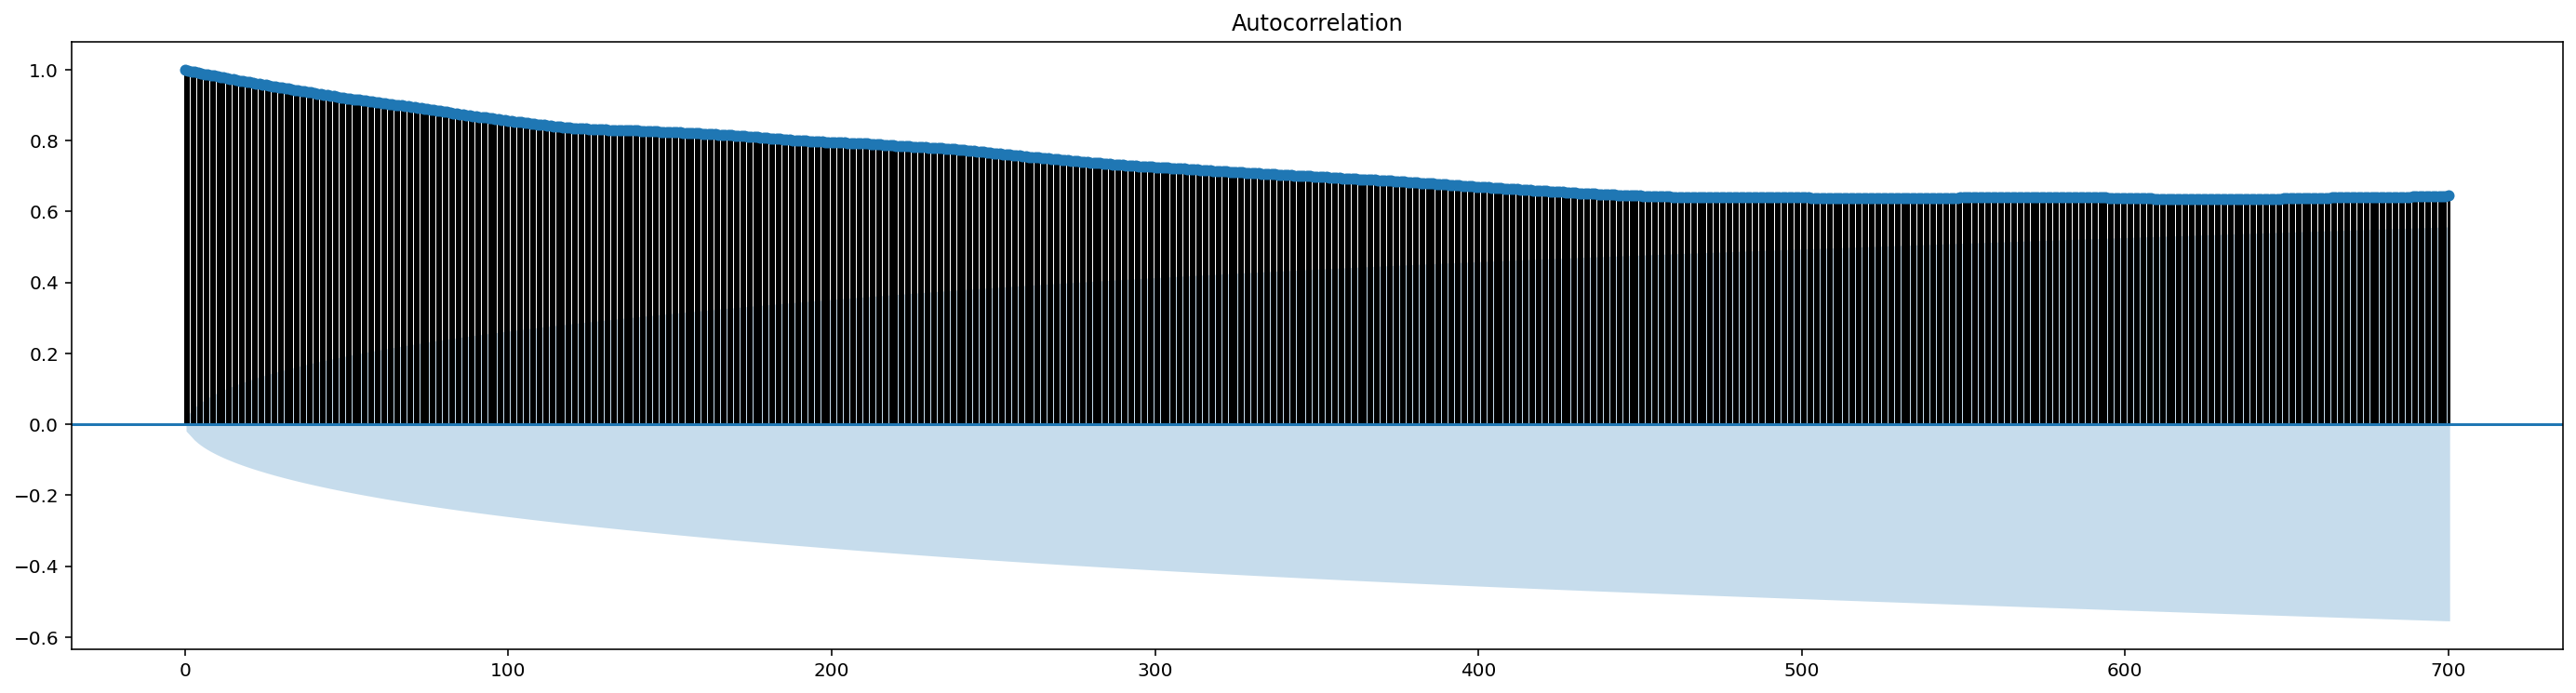

In [141]:
# ACF plot 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_i, lags=700)
plt.show()

In the above correlation plot the cone represents 95% confidence interval.
Notice that we have good positive correlation with the lags upto >700. We cannot use all of those correlations as it will create multi-collinearity problem. Next check on PACF plot to get only the most relevant lags!

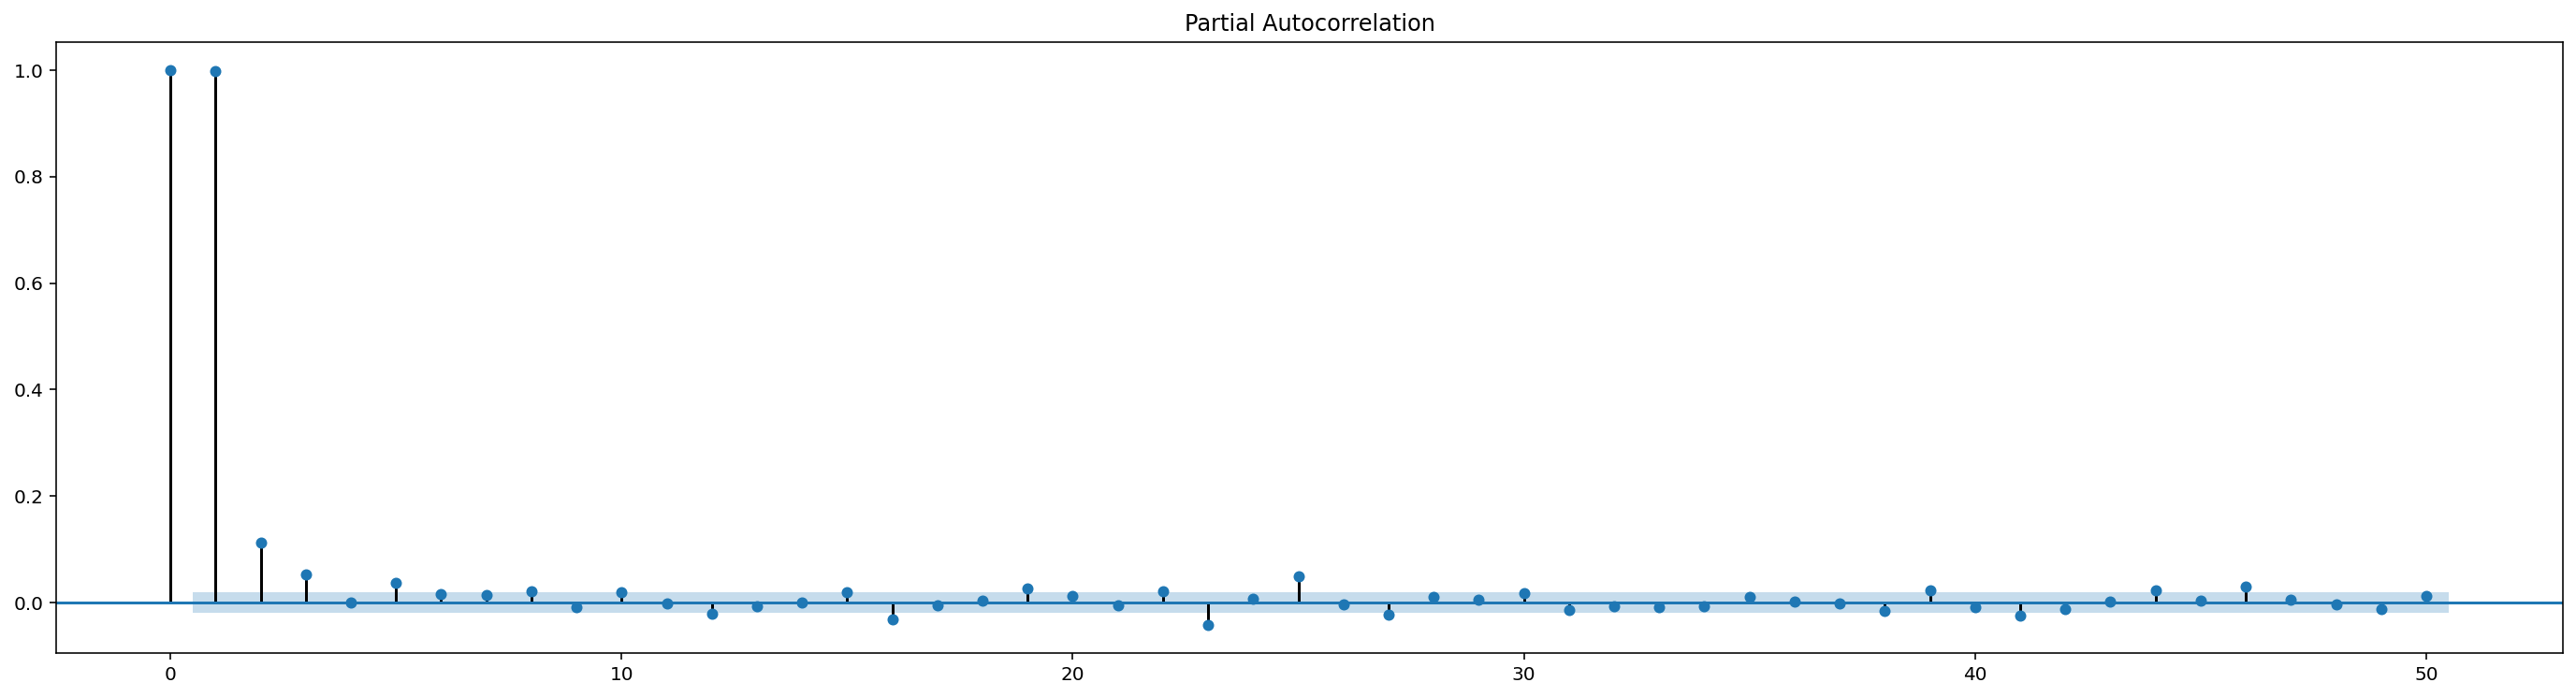

In [143]:
# PACF plot 
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y_i, lags=50, method='ols')
plt.show()

PACF plots show that lags upto 4 have good correlation before the plot first cuts the upper confidence interval. So for the AR process, use lag 4. 

In [129]:
# first see if we can assume there is no trend and seasonal components:
from statsmodels.tsa.seasonal import seasonal_decompose
# see 6 month seasonal component 
period = 30*6 # how many data in 6 mo
s = seasonal_decompose(y_interpolated,
                       period=period,
                       model='additive')

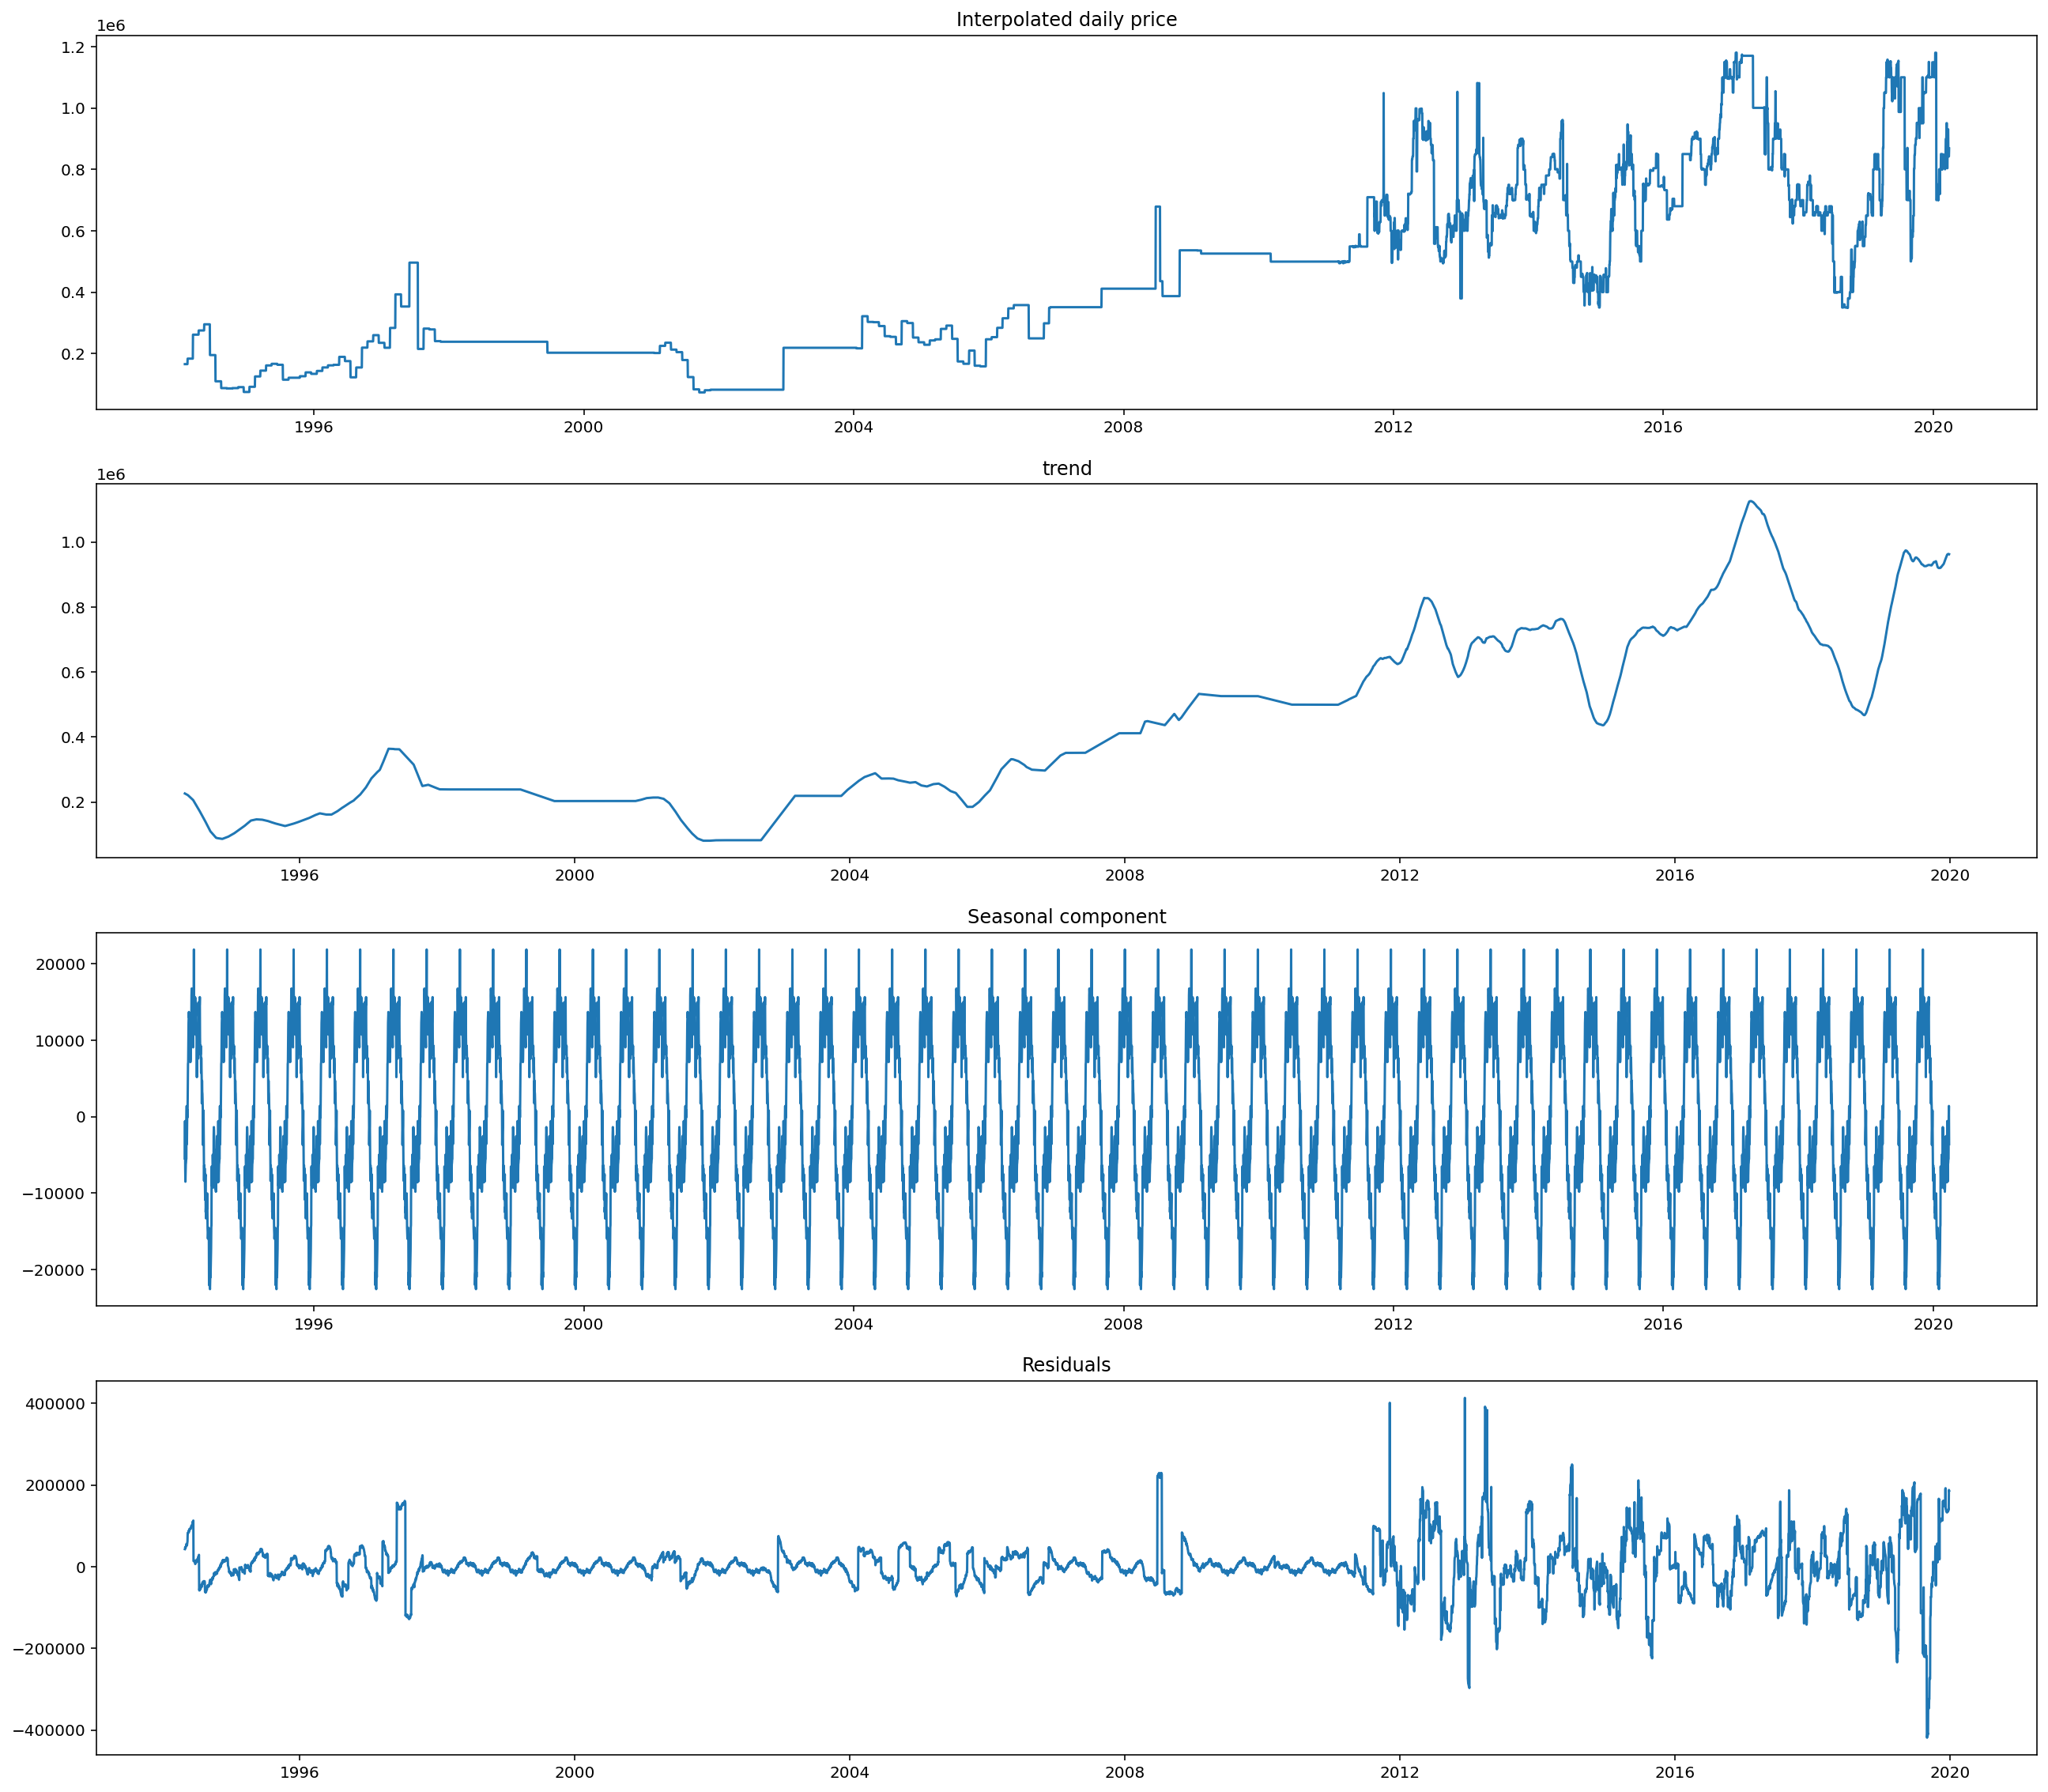

In [134]:
fig = plt.figure(figsize=(22, 20))

ax1=fig.add_subplot(411)
ax1.plot(y_i)
ax1.title.set_text('Interpolated daily price')

ax2=fig.add_subplot(412)
ax2.plot(s.trend)
ax2.title.set_text('trend')

ax1=fig.add_subplot(413)
ax1.plot(s.seasonal)
ax1.title.set_text('Seasonal component')

ax2=fig.add_subplot(414)
ax2.plot(s.resid)
ax2.title.set_text('Residuals')

plt.show()

In [ ]:
# tentatively identify the order of ARMA process, assuming time series is stationary and invertible
from statsmodels.tsa.stattools.arma_order_select_ic as order_select


In [156]:
# split data for cross validation
from sklearn.model_selection import TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=np.round(len(y_i)*0.9))
tscv

TimeSeriesSplit(max_train_size=8597.0, n_splits=5)

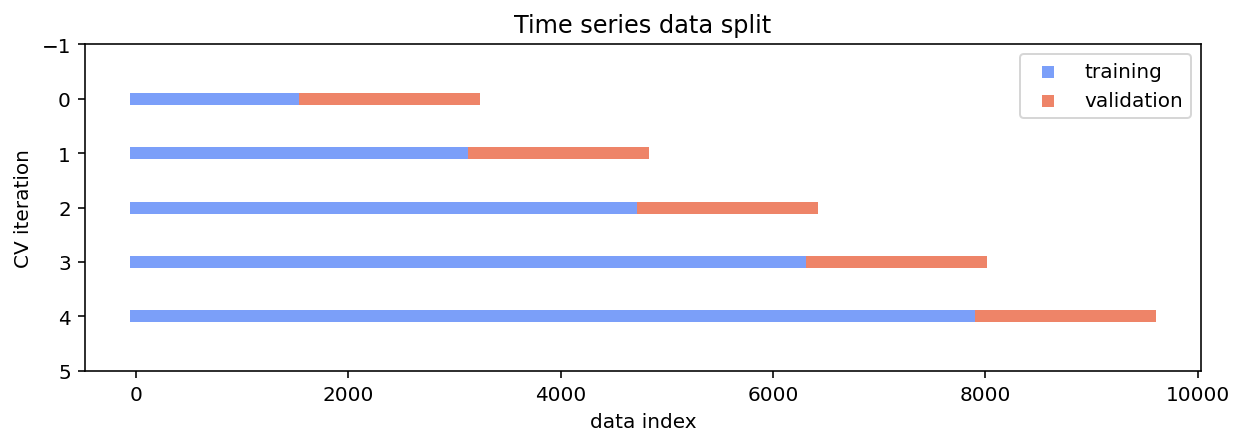

In [159]:
fig, ax = plt.subplots(figsize=(10, 3))
for ii, (train, test) in enumerate(tscv.split(y_i)):
    l1 =ax.scatter(train, [ii]*len(train), c=[plt.cm.coolwarm(.2)], marker='_', lw=6)
    l2 =ax.scatter(test, [ii]*len(test), c=[plt.cm.coolwarm(.8)], marker='_', lw=6)
    ax.set(ylim=[n_splits, -1], title = 'Time series data split',
          xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['training', 'validation'])


In [ ]:
def score_func(estimator, X, y):
    y_pred = estimator.predict(X)
    score = 

In [107]:
# First assume there is no trend nor seasonal components,
# and apply autorgressive integrated moving average (ARIMA) model
from statsmodels.tsa.arima_model import ARIMA
# first trial: lag 1 autogressive term, 1 degree of differencing, first-order ma term, 
model = ARIMA(y_i, order=(4, 1, 1))
model_fit = model.fit()
yt_pred = model_fit.predict(len(y_i), len(y_i))


NameError: name 'y_i' is not defined

In [25]:
np.prod(yt_ma.isnull()) # why the moving avg return all nulls?

wholesale    1
dtype: int64

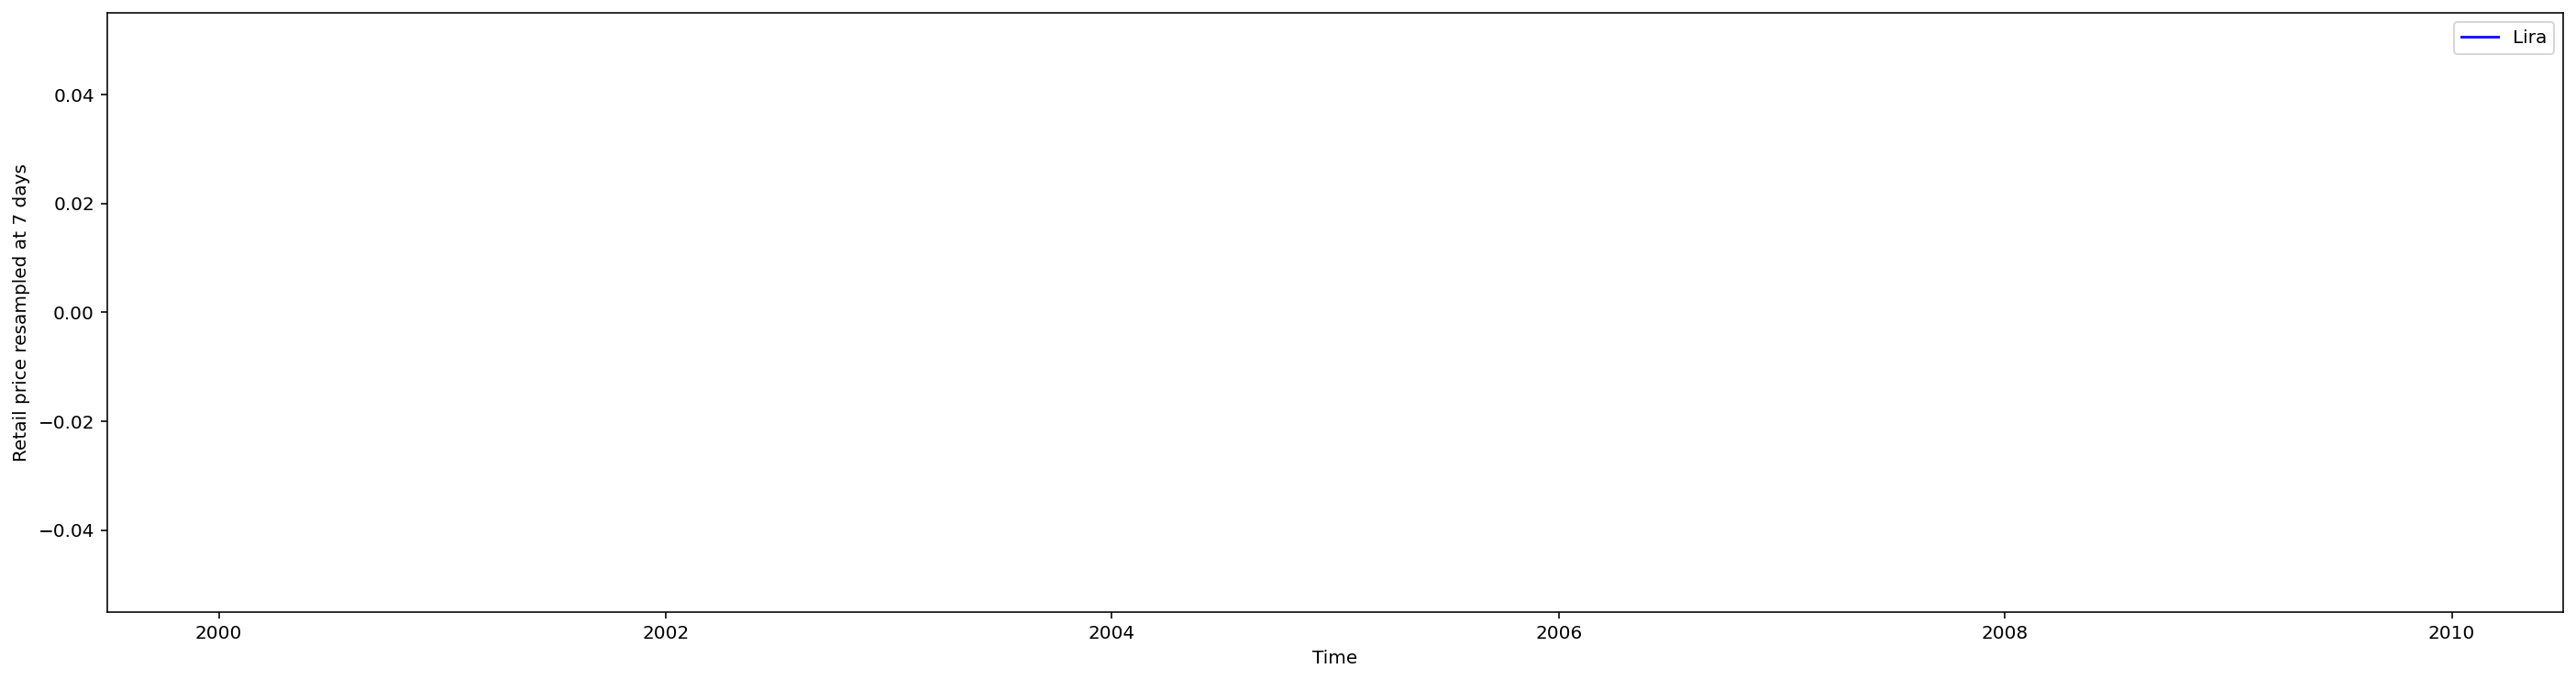

In [22]:
plot_one_time_series(yt_ma)